In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

from data_utils.utils import get_iid_to_ann, load_img, load_ann, paths

In [2]:
images_path = paths["train_img"]
train_ann_path = paths["train_ann"]
val_ann_path = paths["val_ann"]

output_path = "data/output/visualization/challanges.pdf"

In [3]:
def show_img(img, ann=None, title='', scale=4):
    fig, ax = plt.subplots(1,1, figsize=(15/scale,8/scale))
    ax.imshow(img)
    ax.set_title(str(title))
    patches = []
    r = 3
    lw = 3
    if ann:
        for a in ann:
            bbox = a['bbox']
            patches.append(Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], color='red', linewidth=lw, fill=False))

            kp = a['keypoints']
            for i in range(0, len(kp), 3):
                if kp[i+2] > 0:
                    patches.append(Circle((kp[i], kp[i+1]), radius=r, color='red'))
        for p in patches:
            ax.add_patch(p)

def show_img_by_iid(iids, max_img):
    for i, id in enumerate(iids):
        annots = iid_to_ann[id]
        idx = iid_to_idx[id]
        img_name = train_ann['images'][idx]['file_name']
        img = load_img(images_path, img_name)
        show_img(img, annots, title=id)
        if i == max_img:
            break

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)
    return resized


In [4]:
train_ann = load_ann(train_ann_path)
val_ann = load_ann(val_ann_path)

iid_to_ann, iid_to_idx = get_iid_to_ann(val_ann_path, train_ann_path)

In [5]:
def specific_annotations(dataset_ann):
    num_poses = 2
    max_area_ratio = 2     # max diference in bb sizes
    min_img_bb_ratio = 7   # bb size in respect to image %
    max_img_ratio = 1.4    # square images

    # True - condition is met from the start
    _area_ratio = False
    _img_bb_ratio = False
    _no_overlap = False
    _img_ratio = False

    iids = []
    for i in iid_to_ann:
        if len(iid_to_ann[i]) == num_poses:

            area_ratio = _area_ratio
            img_bb_ratio = _img_bb_ratio
            no_overlap = _no_overlap
            img_ratio = _img_ratio

            area1 = iid_to_ann[i][0]['area']
            area2 = iid_to_ann[i][1]['area']

            if area1 > area2:
                ratio = area1/area2
            else:
                ratio = area2/area1
            if ratio < max_area_ratio:
                area_ratio = True

            img_idx = iid_to_idx[i]
            w = dataset_ann['images'][img_idx]['width']
            h = dataset_ann['images'][img_idx]['height']

            if area1/(w*h) > min_img_bb_ratio/100:
                img_bb_ratio = True

            x00 = iid_to_ann[i][0]['bbox'][0]
            x01 = iid_to_ann[i][0]['bbox'][2] + x00
            x10 = iid_to_ann[i][1]['bbox'][0]
            x11 = iid_to_ann[i][1]['bbox'][2] + x10
            if x01 > x11:
                if x11 < x00:
                    no_overlap = True
            else:
                if x01 < x10:
                    no_overlap = True

            if w > h:
                if w/h < max_img_ratio:
                    img_ratio = True
            else:
                if h/w < max_img_ratio:
                    img_ratio = True

            if area_ratio and img_bb_ratio and no_overlap and img_ratio:
                iids.append(i)

    print(len(iids))
    return iids


# rare poses
def rare_poses(iid_to_ann, min_poses = 3, kp_0 = 0, kp_1 = 16):
    # kp_0 = 0   - nose
    # kp_1 = 16  - right ankle
    iids = []

    for i in iid_to_ann:
        if len(iid_to_ann[i]) <= min_poses:
            for j in  range(len(iid_to_ann[i])):

                joints = iid_to_ann[i][j]['keypoints'][1::3]
                vis = iid_to_ann[i][j]['keypoints'][2::3]

                # no oclusion
                next = False
                for v in vis:
                    if v == 1:
                        next = True
                        break
                if next:
                    break

                # nose lower than right ankle
                if joints[kp_0] > 0 and joints[kp_1] > 0 and joints[kp_0] > joints[kp_1]:
                    iids.append(i)
            if next:
                continue

    print(len(iids))
    return iids


#self occlusion
def self_occlusion(iid_to_ann, min_kp = 14, pct_of_area = 0.02):
    # 9,10 - left, right wrist
    potential_kp = [9,10]   #[7,8,9,10]
    iids = []

    for i in iid_to_ann:
        if len(iid_to_ann[i]) == 1:
            x1 = iid_to_ann[i][0]['keypoints'][1::3]
            y1 = iid_to_ann[i][0]['keypoints'][0::3]
            num_keypoints = iid_to_ann[i][0]['num_keypoints']
            area1 = (iid_to_ann[i][0]['area'])**(1/2) * pct_of_area

            add = False
            for k in range(len(x1)):
                for j in range(len(x1)):
                    if k != j and (k in potential_kp or j in potential_kp):
                        dist = ((x1[k] - x1[j])**2 + (y1[k] - y1[j])**2)**(1/2)
                        if dist < area1:
                            add = True

            if add and num_keypoints > min_kp:
                iids.append(i)

    print(len(iids))
    return iids


#environmental occlusion
def environmental_occlusion(iid_to_ann, min_kp = 12, occluded_kp = 6):
    iids = []

    for i in iid_to_ann:
        if len(iid_to_ann[i]) == 1:

            num_keypoints = iid_to_ann[i][0]['num_keypoints']
            vis = iid_to_ann[i][0]['keypoints'][2::3]

            if num_keypoints > min_kp:
                n_kp = 0
                for v in vis:
                    if v == 1:
                        n_kp += 1

                if  n_kp > occluded_kp:
                    iids.append(i)

    print(len(iids))
    return iids


#crowd
def crowd(iid_to_ann, min_kp = 14, min_p = 1, max_p = 5):
    iids = []

    for i in iid_to_ann:
        if len(iid_to_ann[i]) >= min_p and len(iid_to_ann[i]) <= max_p:
            add = True
            for j in range(len(iid_to_ann[i])):
                if iid_to_ann[i][j]['num_keypoints'] < min_kp:
                    add = False
                    break
            if add:
                iids.append(i)

    print(len(iids))
    return iids


# partial pose
def partial_pose(iid_to_ann, max_kp = 5, min_kp = 3, min_poses = 1):
    iids = []
    # specific kp occluded/visible
    kp_0 = 9
    kp_1 = 10

    for i in iid_to_ann:
        if len(iid_to_ann[i]) == min_poses:
            vis = iid_to_ann[i][0]['keypoints'][2::3]
            for j in range(len(iid_to_ann[i])):
                num_keypoints = iid_to_ann[i][j]['num_keypoints']
                if (num_keypoints <= max_kp) and (num_keypoints >= min_kp):
                    if (vis[kp_0] == 2 and vis[kp_1] < 2) or (vis[kp_1] == 2 and vis[kp_0] < 2):
                        iids.append(i)

    print(len(iids))
    return iids

In [6]:
iids_so = self_occlusion(iid_to_ann)
iids_eo = environmental_occlusion(iid_to_ann)
iids_cr = crowd(iid_to_ann)
iids_rp = rare_poses(iid_to_ann)
iids_pp = partial_pose(iid_to_ann)

207
37
12272
152
453


In [7]:
def final_image(challanges, path="", fontsize=45, figsize=[8,8], titles=[]):
    w = []
    h = []
    for i, k in enumerate(challanges):
        ch = challanges[k]
        for j, iid in enumerate(ch):
            idx = iid_to_idx[iid]
            img_name = train_ann['images'][idx]['file_name']
            img = load_img(images_path, img_name)
            s = img.shape
            w.append(s[1])
            h.append(s[0])

    cols = len(challanges)
    rows = []
    for k in challanges:
        rows.append(len(challanges[k]))
    rows = np.max(rows)

    fig, axs = plt.subplots(rows, cols, figsize=(figsize[0]*cols, figsize[1]*rows), tight_layout=True)

    for i, k in enumerate(challanges):
        ch = challanges[k]
        for j, iid in enumerate(ch):
            if j == 0:
                title = k.replace('-', ' ')
                if titles:
                    title = titles[i]
                axs[j][i].set_title(title, fontsize=fontsize)
            if i == 0:
                axs[j][i].set_ylabel(f'Example {j+1}', fontsize=fontsize)
            idx = iid_to_idx[iid]
            img_name = train_ann['images'][idx]['file_name']
            img = load_img(images_path, img_name)
            pad = np.ones([np.max(h), np.max(w), 3], dtype='uint8')*255
            sh1 = np.array(img.shape[0:2])
            sh2 = np.array(pad.shape[0:2])
            if sh1[0] < sh1[1]:
                if sh1[1] < sh2[1]:
                    img = image_resize(img, width = sh2[1])
                    sh1 = np.array(img.shape[0:2])
            else:
                if sh1[0] < sh2[0]:
                    img = image_resize(img, height = sh2[0])
                    sh1 = np.array(img.shape[0:2])

            sh = (sh2-sh1)/2
            pad[int(sh[0]):int(sh[0])+sh1[0] , int(sh[1]):int(sh[1])+sh1[1]] = img

            axs[j][i].imshow(pad) #, aspect="auto"
            axs[j][i].set_xticks([])
            axs[j][i].set_yticks([])
            axs[j][i].spines['top'].set_visible(False)
            axs[j][i].spines['right'].set_visible(False)
            axs[j][i].spines['bottom'].set_visible(False)
            axs[j][i].spines['left'].set_visible(False)

            #axs[j][i].axis('off')
    """
    from matplotlib.pyplot import gcf
    axs[0][0].plot([1/7, 1/7], [0, 1], color='grey', lw=2, alpha=0.5, transform=gcf().transFigure, clip_on=False)
    axs[0][0].plot([2/7, 2/7], [0, 1], color='grey', lw=2, alpha=0.5, transform=gcf().transFigure, clip_on=False)
    axs[0][0].plot([3/7, 3/7], [0, 1], color='grey', lw=2, alpha=0.5, transform=gcf().transFigure, clip_on=False)
    axs[0][0].plot([4/7, 4/7], [0, 1], color='grey', lw=2, alpha=0.5, transform=gcf().transFigure, clip_on=False)
    axs[0][0].plot([5/7, 5/7], [0, 1], color='grey', lw=2, alpha=0.5, transform=gcf().transFigure, clip_on=False)
    axs[0][0].plot([6/7, 6/7], [0, 1], color='grey', lw=2, alpha=0.5, transform=gcf().transFigure, clip_on=False)
    """

    if path:
        fig.savefig(path, bbox_inches='tight')

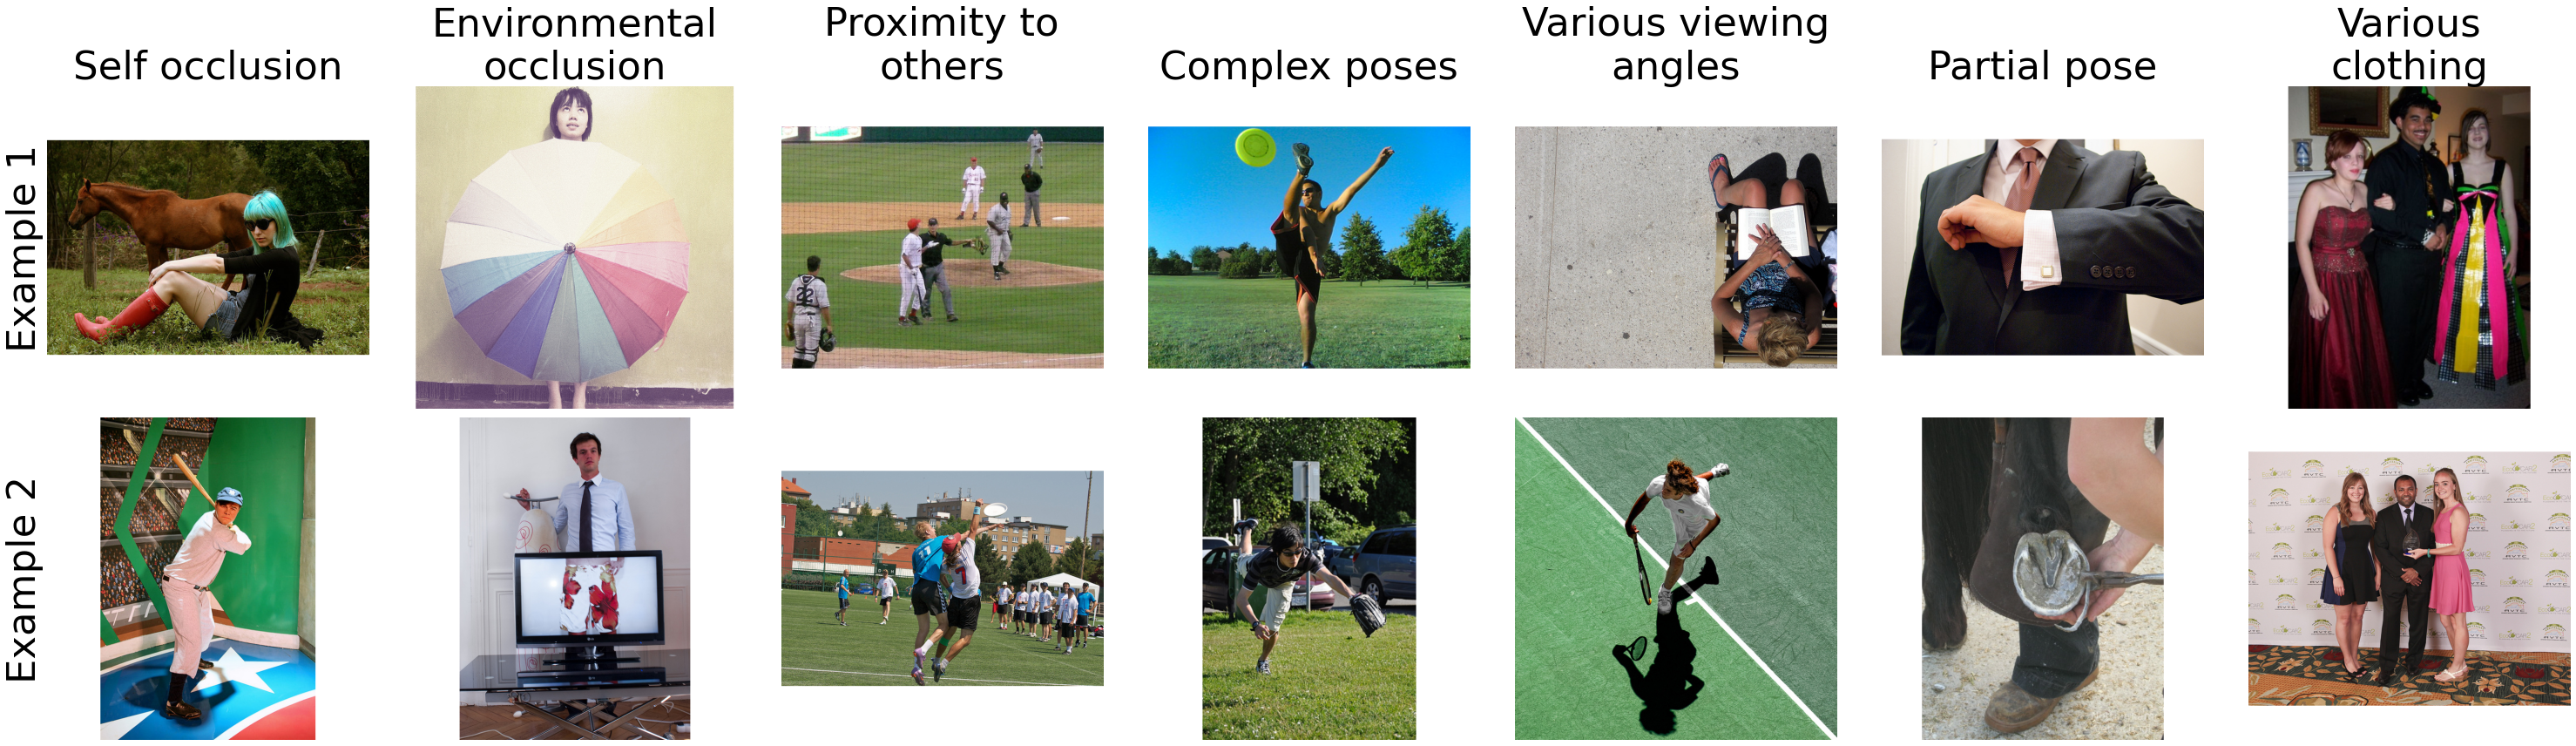

In [8]:
challanges = {'Self-occlusion' : [57550, 54664], 'Environmental-occlusion' : [217583,404698], 'Proximity-to-others' : [94326,96825],
              'Complex-poses' : [503600,426031], 'Various-viewing-angles' : [3786, 402916], 'Partial-pose' : [521978,97428], 'Various-clothing' : [479779,577586] }

titles =['Self occlusion',
         'Environmental\nocclusion',
         'Proximity to\nothers',
         'Complex poses',
         'Various viewing\nangles',
         'Partial pose',
         'Various\nclothing']
final_image(challanges, path=output_path, fontsize=45, figsize=[6,6], titles=titles)